# Import Libraries

In [42]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

#import tensorflow_io as tfio

import IPython.display as ipd

import tensorflow as tf
from tensorflow.keras import layers, models
#from transformers import Wav2Vec2Model, Wav2Vec2Processor,TrainingArguments, Wav2Vec2ForSequenceClassification

In [43]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exact Dataset Path

In [44]:
#from google.colab import drive
#drive.mount('/content/drive/')

# Replace with your actual dataset folder path
dataset_path = r'C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset'
x = 0
for root, dirs, files in os.walk(dataset_path):

    for file in files:
        if file.endswith('.wav'):  # Assuming your audio files are in .wav format
            print(os.path.join(root, file))
            x = x + 1

print("Total files = ", x)

C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-01-01-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-01-02-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-01-03-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-02-01-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-02-02-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-02-03-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-03-01-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-03-02-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-03-03-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-02-01-01-01-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-02-01-01-02-01.wav
C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01

# Load Audio Dataset Function

In [45]:
def load_audio_dataset(dataset_path):
    paths = []
    labels = []

    label_mapping = {
        "01": "happy",
        "02": "sad",
        "03": "angry",
        "04": "surprise",
        "05": "neutral"
    }

    for actor in range(1, 35):  # Loop through Actor 01 to Actor 34
        actor_folder = f"Actor {actor:02d}"  # Format as 'Actor 01', 'Actor 02', ...
        actor_path = os.path.join(dataset_path, actor_folder)

        if not os.path.isdir(actor_path):
            continue

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Ensure it's an audio file
                parts = file.split("-")
                if len(parts) < 3:
                    continue

                emotion_label = parts[2]  # 3rd number in filename
                emotion = label_mapping.get(emotion_label, "unknown")

                file_path = os.path.join(actor_path, file)
                paths.append(file_path)
                labels.append(emotion)

    return paths, labels

# Example usage
# current_dir = os.getcwd() # Get the current script directory
# dataset_path = os.path.join(current_dir, "B-SER dataset")
paths, labels = load_audio_dataset(dataset_path)

print(f"Loaded {len(paths)} audio files")
print(f"Sample path: {paths[0]}")
print(f"Sample label: {labels[0]}")

Loaded 1467 audio files
Sample path: C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-01-01-01.wav
Sample label: happy


# KUET and BANGLASER mixing

In [76]:
import os
import noisereduce as nr
import scipy.io.wavfile as wav
import numpy as np

# Function to load the first dataset
def load_audio_dataset(dataset_path):
    paths = []
    labels = []

    label_mapping = {
        "01": "happy",
        "02": "sad",
        "03": "angry",
        "04": "surprise",
        "05": "neutral"
    }

    for actor in range(1, 35):  # Loop through Actor 01 to Actor 34
        actor_folder = f"Actor {actor:02d}"  # Format as 'Actor 01', 'Actor 02', ...
        actor_path = os.path.join(dataset_path, actor_folder)

        if not os.path.isdir(actor_path):
            continue

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Ensure it's an audio file
                parts = file.split("-")
                if len(parts) < 3:
                    continue

                emotion_label = parts[2]  # 3rd number in filename
                emotion = label_mapping.get(emotion_label, "unknown")

                file_path = os.path.join(actor_path, file)
                paths.append(file_path)
                labels.append(emotion)

    return paths, labels

# Function to load the second dataset
def load_mendeley_dataset(dataset_path):
    paths = []
    labels = []

    label_mapping = {
        "Angry (High)": "angry",
        "Angry (Low)": "angry",
        "Disgust (High)": "disgust",
        "Disgust (Low)": "disgust",
        "Happy (High)": "happy",
        "Happy (Low)": "happy",
        "Neutral": "neutral",
        "Sad (High)": "sad",
        "Sad (Low)": "sad"
    }

    for emotion_folder in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_folder)

        if not os.path.isdir(emotion_path):
            continue

        # Extract label from folder name
        emotion_label = label_mapping.get(emotion_folder)

        if emotion_label is None:
            print(f"Skipping folder {emotion_folder} as it does not match any known emotion")
            continue

        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)
                paths.append(file_path)
                labels.append(emotion_label)
            
    return paths, labels

# Function to reduce noise and save files
def reduce_noise_and_save(paths, labels, dataset_path, output_path, chunk_size=44100):
    reduced_paths = []
    reduced_labels = []

    # Check if the output folder is empty
    if os.path.exists(output_path) and os.listdir(output_path):
        print("Output folder is not empty. Skipping noise reduction and loading existing files.")
        return load_existing_files(output_path, labels)

    for i, (file_path, label) in enumerate(zip(paths, labels)):
        try:
            # Load the audio file
            rate, data = wav.read(file_path)

            # If the audio is stereo, convert it to mono
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)

            # Process the audio in chunks
            reduced_noise = np.zeros_like(data, dtype=np.float32)
            for start in range(0, len(data), chunk_size):
                end = start + chunk_size
                chunk = data[start:end]

                # Reduce noise for the chunk
                reduced_chunk = nr.reduce_noise(y=chunk, sr=rate, n_fft=1024)

                # Store the reduced chunk
                reduced_noise[start:end] = reduced_chunk

            # Create the output directory structure
            relative_path = os.path.relpath(file_path, dataset_path)
            output_file_path = os.path.join(output_path, relative_path)
            os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

            # Save the reduced audio file
            wav.write(output_file_path, rate, reduced_noise.astype(np.int16))

            # Append the new path and label
            reduced_paths.append(output_file_path)
            reduced_labels.append(label)

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(paths)} files")

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return reduced_paths, reduced_labels

# Function to load existing files from the output folder
def load_existing_files(output_path, original_labels):
    reduced_paths = []
    reduced_labels = []

    # Walk through the output folder and collect all .wav files
    for root, _, files in os.walk(output_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                reduced_paths.append(file_path)

                # Match the label with the original dataset
                relative_path = os.path.relpath(file_path, output_path)
                original_index = len(reduced_paths) - 1
                if original_index < len(original_labels):
                    reduced_labels.append(original_labels[original_index])
                else:
                    reduced_labels.append("unknown")

    print(f"Loaded {len(reduced_paths)} existing files from the output folder.")
    return reduced_paths, reduced_labels

# Load the first dataset
dataset_path = r'C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset'
paths1, labels1 = load_audio_dataset(dataset_path)

# Load the second dataset
mendeley_dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\KUET Bangla Emotional Speech (KBES) Dataset"  # Replace with the actual path
paths2, labels2 = load_mendeley_dataset(mendeley_dataset_path)

# Output path for reduced audio files
output_path = r"C:\Users\Jim\Jupiter Projects\CSE499\Reduced_KBES_Dataset"  # Replace with your desired output path

# Reduce noise and save the second dataset (only if output folder is empty)
reduced_paths2, reduced_labels2 = reduce_noise_and_save(paths2, labels2, mendeley_dataset_path, output_path)

# Combine the datasets
paths = paths1 + reduced_paths2
labels = labels1 + reduced_labels2

print(f"Total Loaded Audio Files: {len(paths)}")
print(f"B-SER dataset size: {len(paths1)}")
print(f"Reduced Mendeley dataset size: {len(reduced_paths2)}")
print(f"Sample path: {paths[0]}")
print(f"Sample label: {labels[0]}")
print(f"Sample path: {paths[-1]}")
print(f"Sample label: {labels[-1]}")

Output folder is not empty. Skipping noise reduction and loading existing files.
Loaded 900 existing files from the output folder.
Total Loaded Audio Files: 2367
B-SER dataset size: 1467
Reduced Mendeley dataset size: 900
Sample path: C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset\Actor 01\03-01-01-01-01-01-01.wav
Sample label: happy
Sample path: C:\Users\Jim\Jupiter Projects\CSE499\Reduced_KBES_Dataset\Sad (Low)\3-1-1-050.wav
Sample label: sad


# Play Audio Function

In [47]:
def play_audio(file_path, use_ipython=True):
    if use_ipython:
        return ipd.Audio(file_path)
    else:
        audio = AudioSegment.from_wav(file_path)
        play(audio)

# Testing

In [48]:
print(os.listdir(dataset_path))
print(os.listdir(mendeley_dataset_path))

['Actor 01', 'Actor 02', 'Actor 03', 'Actor 04', 'Actor 05', 'Actor 06', 'Actor 07', 'Actor 08', 'Actor 09', 'Actor 10', 'Actor 11', 'Actor 12', 'Actor 13', 'Actor 14', 'Actor 15', 'Actor 16', 'Actor 17', 'Actor 18', 'Actor 19', 'Actor 20', 'Actor 21', 'Actor 22', 'Actor 23', 'Actor 24', 'Actor 25', 'Actor 26', 'Actor 27', 'Actor 28', 'Actor 29', 'Actor 30', 'Actor 31', 'Actor 32', 'Actor 33', 'Actor 34']
['Angry (High)', 'Angry (Low)', 'Disgust (High)', 'Disgust (Low)', 'Happy (High)', 'Happy (Low)', 'Neutral', 'Sad (High)', 'Sad (Low)']


In [49]:
play_audio(paths[0])

In [50]:
# paths[:]

In [51]:
labels[:5]

['happy', 'happy', 'happy', 'happy', 'happy']

# Create DataFrame

In [52]:
df = pd.DataFrame()
df['audioPaths'] = paths
df['labels'] = labels
#df = df.drop(df[df['labels'] == 'disgust'].index).reset_index(drop=True)

df.head()

audioPaths labels
0  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...  happy
1  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...  happy
2  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...  happy
3  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...  happy
4  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...  happy

# Dataframe Details

In [53]:
df['labels'].value_counts()

happy       506
sad         506
angry       506
neutral     343
surprise    306
disgust     200
Name: labels, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

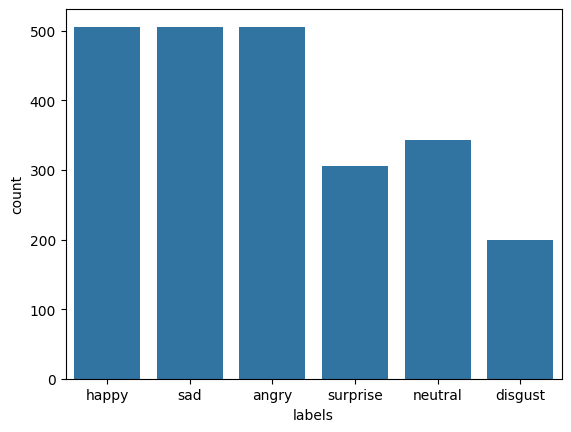

In [54]:
sns.countplot(data = df, x = 'labels')

# Waveplot Functions

In [55]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size = 20)
    librosa.display.waveshow(data,sr = sr)
    plt.show()

In [56]:
def spectogram(data, sr, emmotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size = 20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')

# Waveplot Test

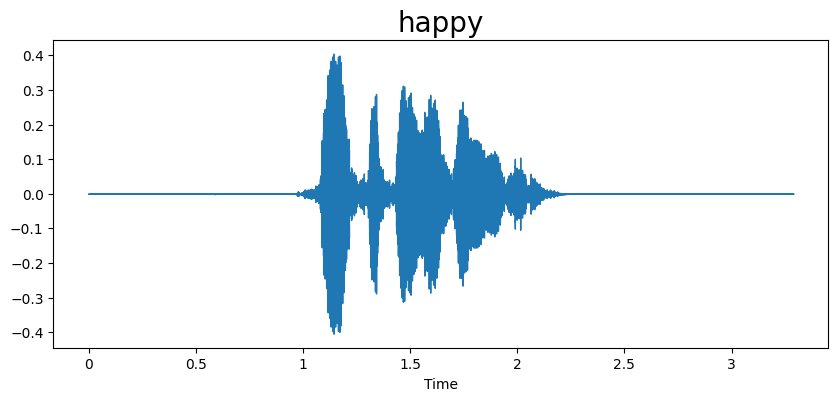

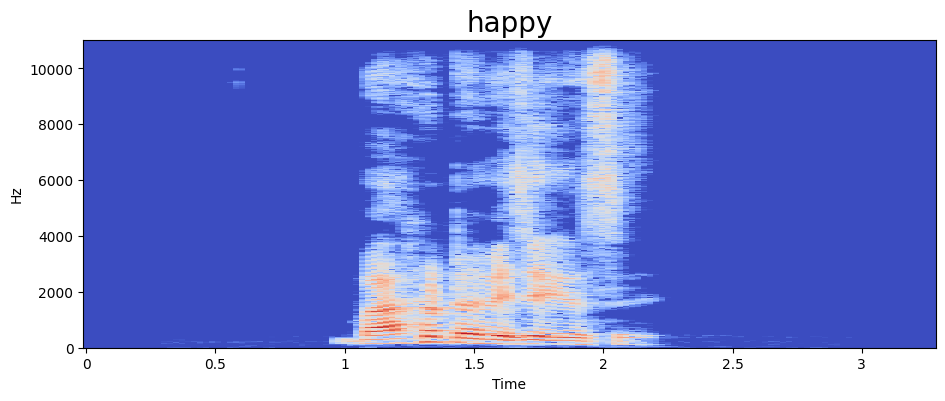

In [57]:
emotion = 'happy'
path = np.array(df['audioPaths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

# Waveplot 1 Example of each Target Class

Emotion: happy


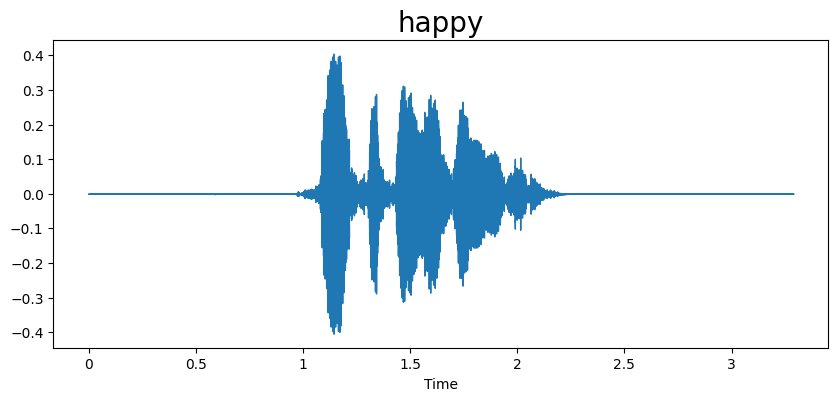


--------------------------------------------------

Emotion: sad


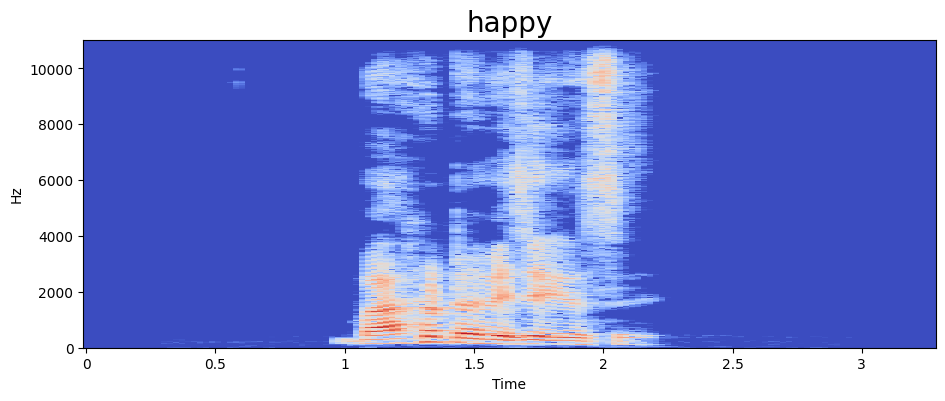

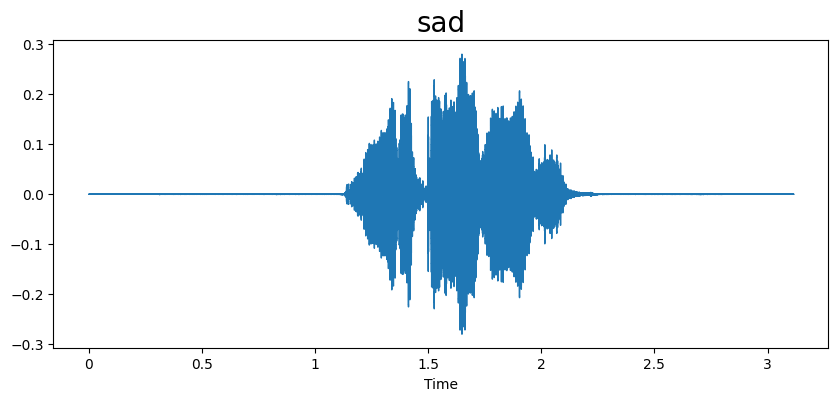


--------------------------------------------------

Emotion: angry


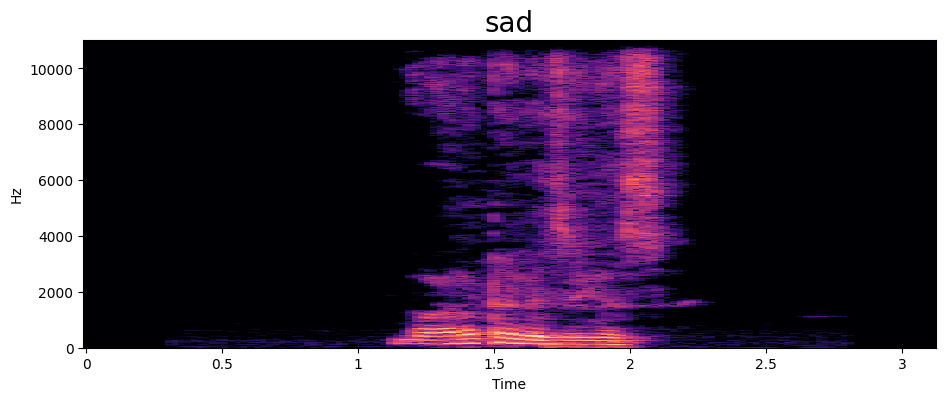

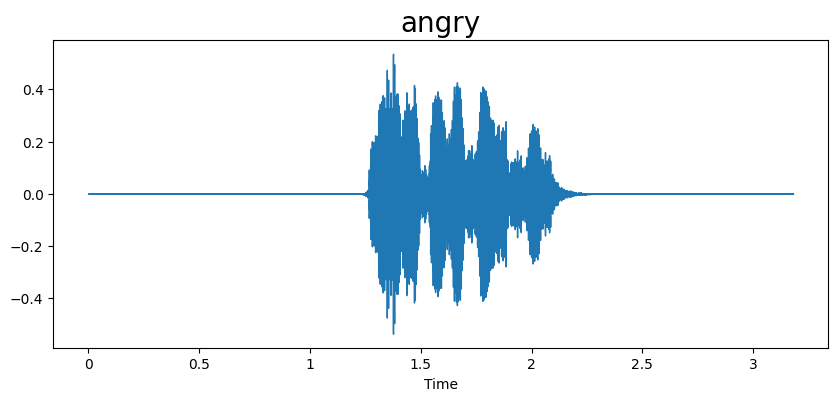


--------------------------------------------------

Emotion: surprise


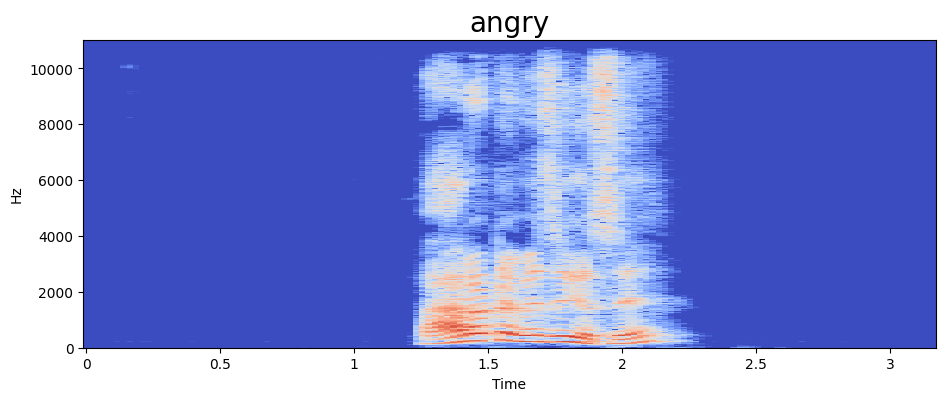

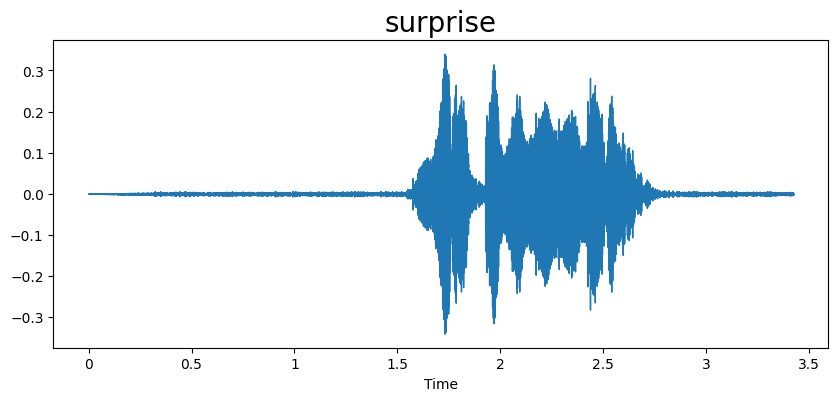


--------------------------------------------------

Emotion: neutral


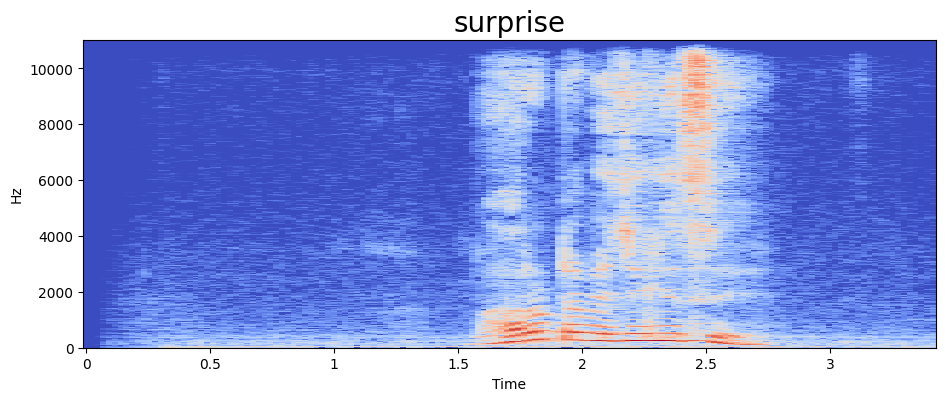

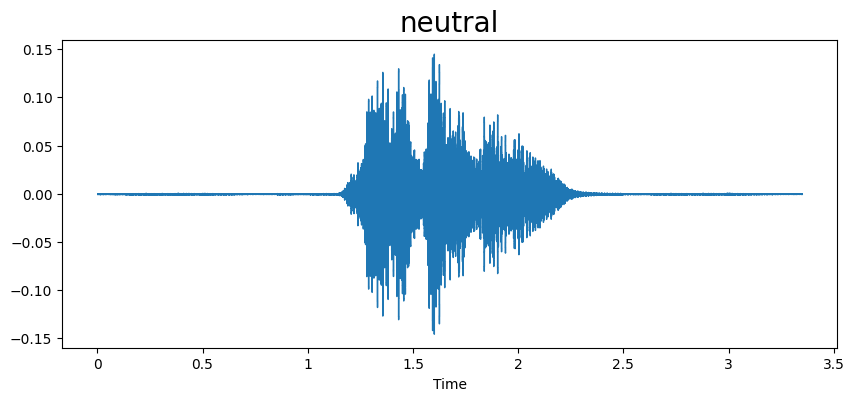


--------------------------------------------------

Emotion: disgust


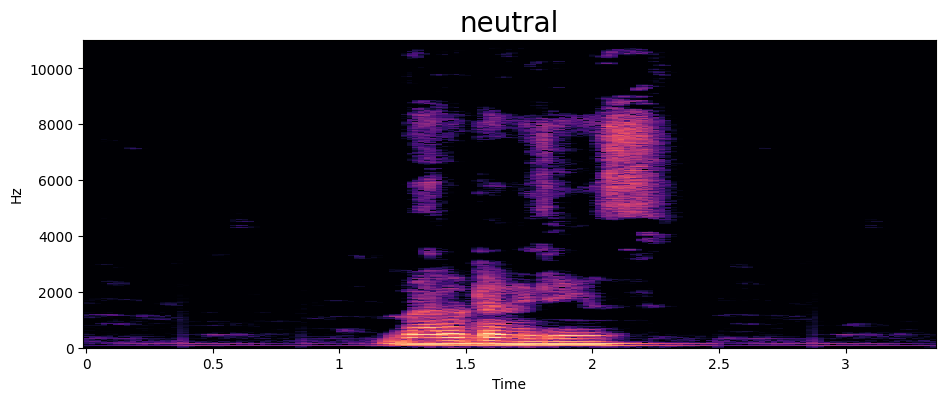

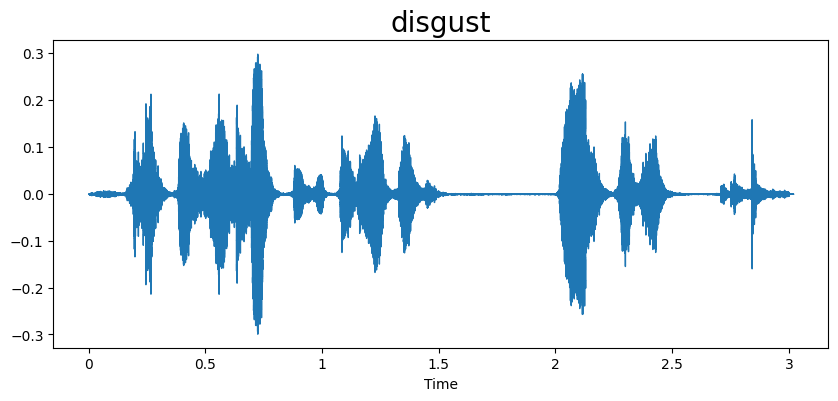


--------------------------------------------------



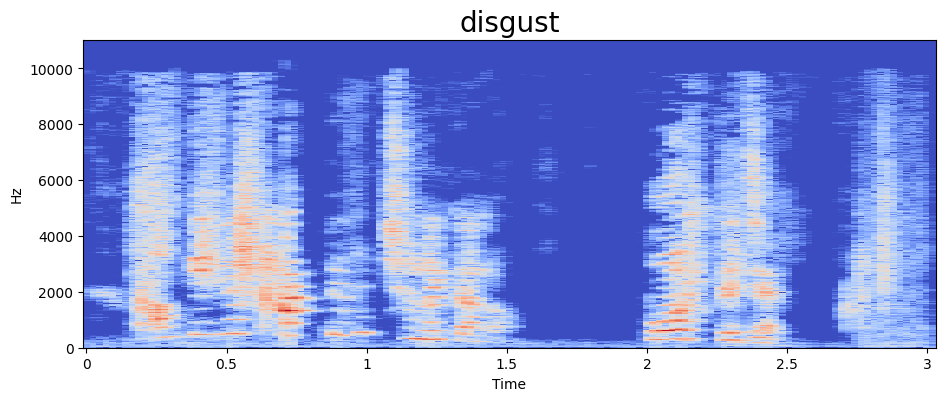

In [58]:
# Get unique emotion classes
unique_emotions = df['labels'].unique()

# Loop through each emotion and display one example
for emotion in unique_emotions:
    path = np.array(df['audioPaths'][df['labels'] == emotion])[0]  # Get one sample for each emotion
    data, sampling_rate = librosa.load(path)

    print(f"Emotion: {emotion}")

    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)

    display(Audio(path))  # Play the audio
    print("\n" + "-"*50 + "\n")  # Separator for clarity

In [59]:
from sklearn.model_selection import train_test_split

def stratified_split(df, test_size=0.15, val_size=0.15):
    train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df['labels'], random_state=42)

    val_size_adjusted = val_size / (1 - test_size)

    train_df, val_df = train_test_split(train_val_df, test_size=val_size_adjusted, stratify=train_val_df['labels'], random_state=42)

    return train_df, val_df, test_df

# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Perform stratified split
train_df, val_df, test_df = stratified_split(df, test_size=test_ratio, val_size=val_ratio)

# Verify distribution of emotion classes in each split
train_distribution = train_df['labels'].value_counts(normalize=True)
val_distribution = val_df['labels'].value_counts(normalize=True)
test_distribution = test_df['labels'].value_counts(normalize=True)

print("Train set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)
print("Test set distribution:", test_distribution)

Train set distribution: angry       0.213768
happy       0.213768
sad         0.213768
neutral     0.144928
surprise    0.129227
disgust     0.084541
Name: labels, dtype: float64
Validation set distribution: happy       0.215190
angry       0.215190
sad         0.210970
neutral     0.143460
surprise    0.130802
disgust     0.084388
Name: labels, dtype: float64
Test set distribution: sad         0.215190
happy       0.213080
angry       0.213080
neutral     0.145570
surprise    0.128692
disgust     0.084388
Name: labels, dtype: float64


In [60]:
def check_audio_length(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)  # sr=None keeps the original sampling rate

    # Calculate the duration
    duration = len(audio) / sr  # Duration in seconds
    return duration

# Example usage:
train_df['audio_length'] = train_df['audioPaths'].apply(check_audio_length)

val_df['audio_length'] = val_df['audioPaths'].apply(check_audio_length)
test_df['audio_length'] = test_df['audioPaths'].apply(check_audio_length)

print(train_df[['audioPaths', 'audio_length']])
print(val_df[['audioPaths', 'audio_length']])
print(test_df[['audioPaths', 'audio_length']])


                                             audioPaths  audio_length
1136  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.779751
718   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.727574
1331  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.314989
1975  C:\Users\Jim\Jupiter Projects\CSE499\Reduced_K...      3.018604
1087  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.350499
...                                                 ...           ...
1035  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.755714
1726  C:\Users\Jim\Jupiter Projects\CSE499\Reduced_K...      3.018604
433   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.072687
563   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.668125
885   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.852653

[1656 rows x 2 columns]
                                             audioPaths  audio_length
793   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...      3.31

In [61]:
# Define the target length in samples (3.5 seconds at 44.1 kHz)
target_length = int(3.5 * 44100)

def standardize_audio_length(file_path, target_length):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=44100)

    # Standardize the length
    if len(audio) < target_length:
        # Zero padding for shorter files
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        # Truncate longer files
        audio = audio[:target_length]

    return audio

# Apply the standardization to all audio files in the dataframe
train_df['standardized_audio'] = train_df['audioPaths'].apply(lambda x: standardize_audio_length(x, target_length))
val_df['standardized_audio'] = val_df['audioPaths'].apply(lambda x: standardize_audio_length(x, target_length))
test_df['standardized_audio'] = test_df['audioPaths'].apply(lambda x: standardize_audio_length(x, target_length))

In [62]:
def check_audio_length(audio, sr=44100):
    # Calculate the duration
    duration = len(audio) / sr  # Duration in seconds
    return duration
train_df['audio_length'] = train_df['standardized_audio'].apply(lambda x: check_audio_length(x))
print(train_df[['audioPaths', 'audio_length']])

val_df['audio_length'] = val_df['standardized_audio'].apply(lambda x: check_audio_length(x))
print(val_df[['audioPaths', 'audio_length']])

test_df['audio_length'] = test_df['standardized_audio'].apply(lambda x: check_audio_length(x))
print(test_df[['audioPaths', 'audio_length']])

from IPython.display import Audio

# Function to play audio
def play_audio(audio, sr=44100):
    return Audio(audio, rate=sr)

# Play the first 5 standardized audio files
for i in range(5):
    print(f"Playing audio file {i+1}:")
    display(play_audio(train_df['standardized_audio'].iloc[i]))
    display(train_df['standardized_audio'].iloc[i])


                                             audioPaths  audio_length
1136  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
718   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
1331  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
1975  C:\Users\Jim\Jupiter Projects\CSE499\Reduced_K...           3.5
1087  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
...                                                 ...           ...
1035  C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
1726  C:\Users\Jim\Jupiter Projects\CSE499\Reduced_K...           3.5
433   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
563   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5
885   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...           3.5

[1656 rows x 2 columns]
                                             audioPaths  audio_length
793   C:\Users\Jim\Jupiter Projects\CSE499\B-SER dat...          

array([ 0.00250244,  0.00250244,  0.00244141, ..., -0.00059509,
       -0.0004425 , -0.00050354], dtype=float32)

Playing audio file 2:


array([ 0.00276184,  0.00263977,  0.00294495, ..., -0.00350952,
       -0.00364685, -0.00372314], dtype=float32)

Playing audio file 3:


array([ 1.5258789e-05, -3.0517578e-05,  3.0517578e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

Playing audio file 4:


array([0.02931213, 0.03986843, 0.03214962, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Playing audio file 5:


array([0.00015259, 0.00030518, 0.00018311, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def extract_mfcc(audio, sr=44100, n_mfcc=40, n_fft=1024, hop_length=512):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

def pad_or_truncate(mfcc, target_length=300):
    if mfcc.shape[1] < target_length:
        pad_width = target_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :target_length]
    return mfcc

# Apply MFCC extraction and padding to the standardized audio data
train_df['mfcc_features'] = train_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))

# Flatten MFCC features for scaling
mfcc_features = np.array(train_df['mfcc_features'].tolist())
mfcc_flattened = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Scale the flattened MFCC features
scaler = MinMaxScaler()
scaled_mfcc = scaler.fit_transform(mfcc_flattened)

# Reshape back to original dimensions
scaled_mfcc = scaled_mfcc.reshape(mfcc_features.shape)

# Update the DataFrame with scaled MFCC features
train_df['mfcc_features'] = list(scaled_mfcc)

print("MFCC shape for the first 5 samples after scaling:")
for i in range(5):
    print(f"Sample {i+1}: {train_df['mfcc_features'].iloc[i].shape}")



MFCC shape for the first 5 samples after scaling:
Sample 1: (40, 300)
Sample 2: (40, 300)
Sample 3: (40, 300)
Sample 4: (40, 300)
Sample 5: (40, 300)


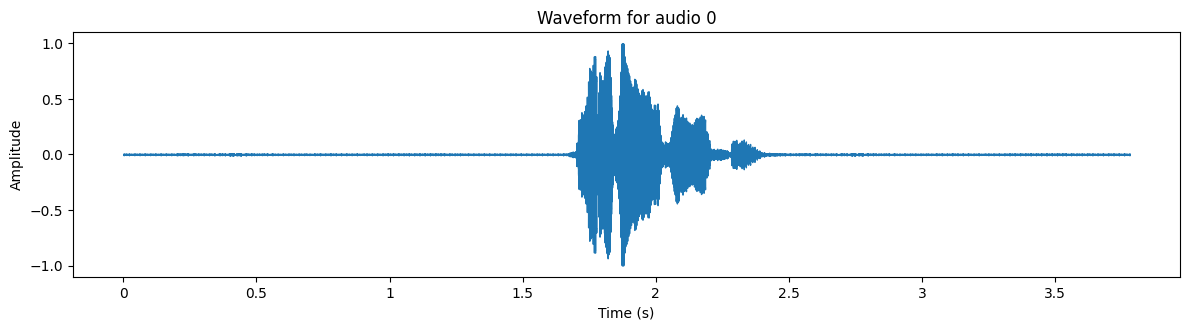

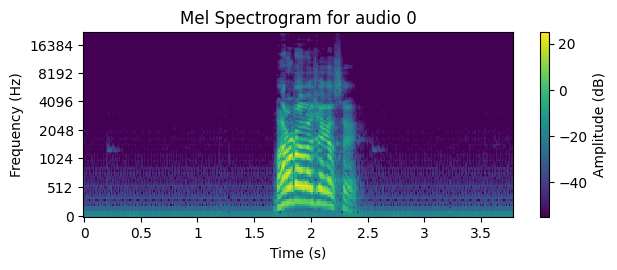

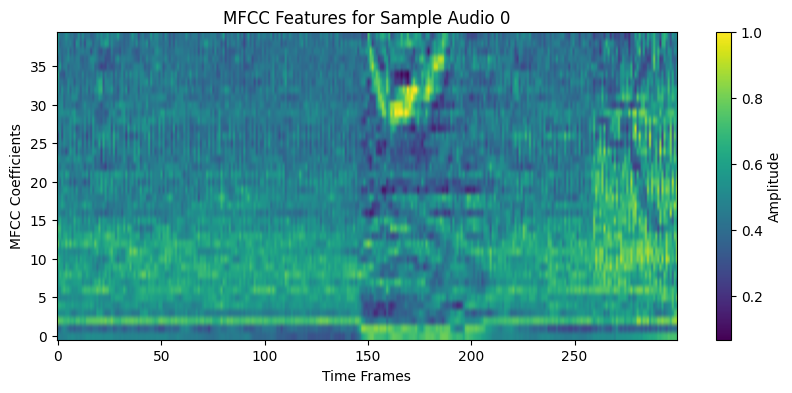

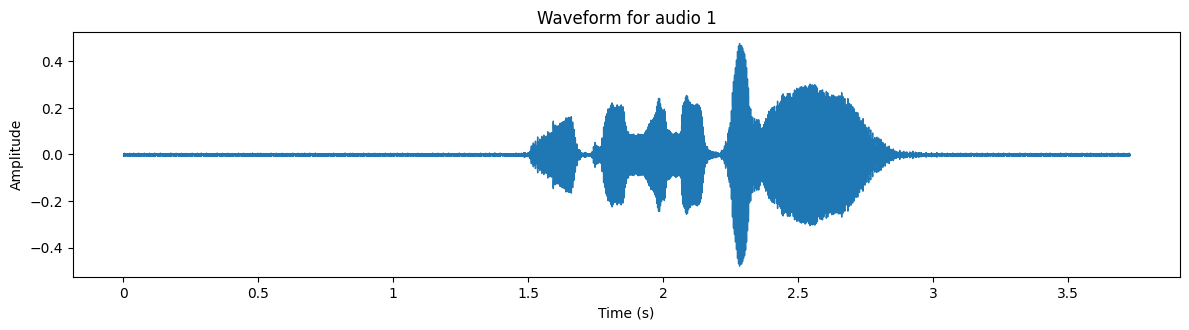

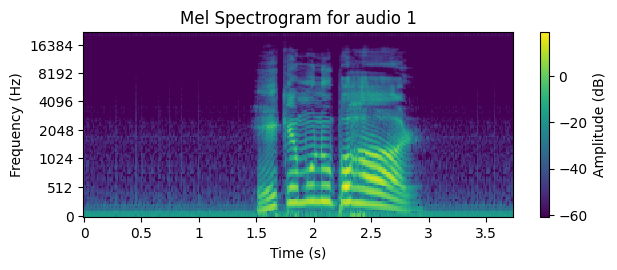

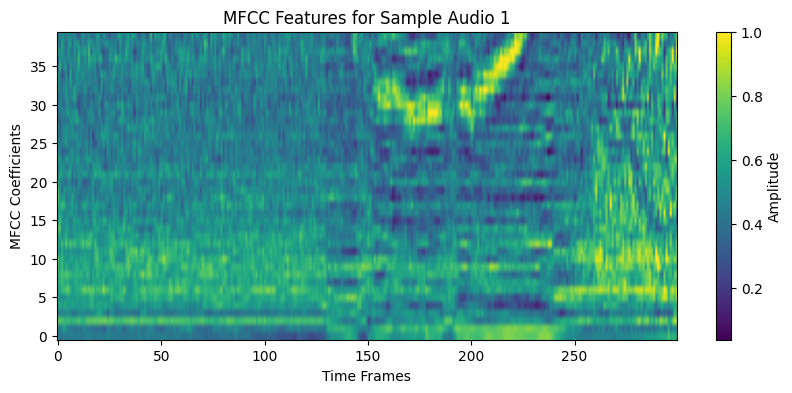

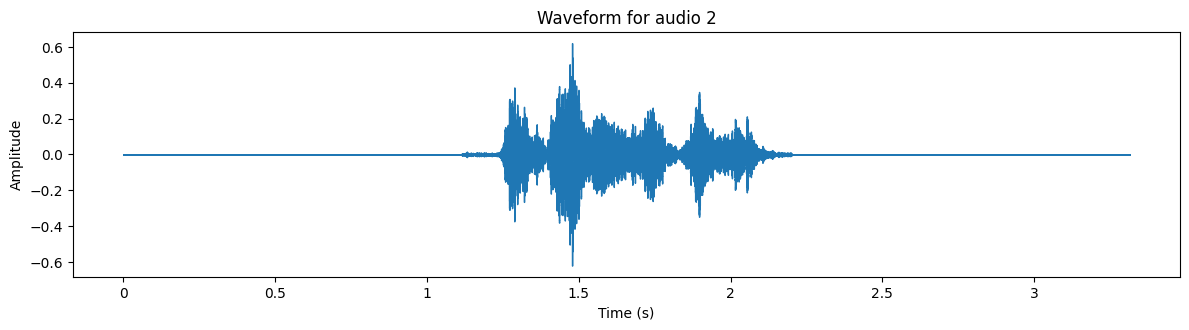

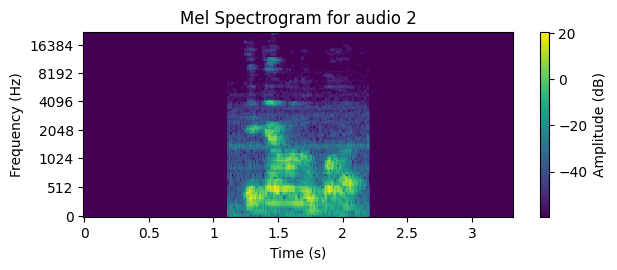

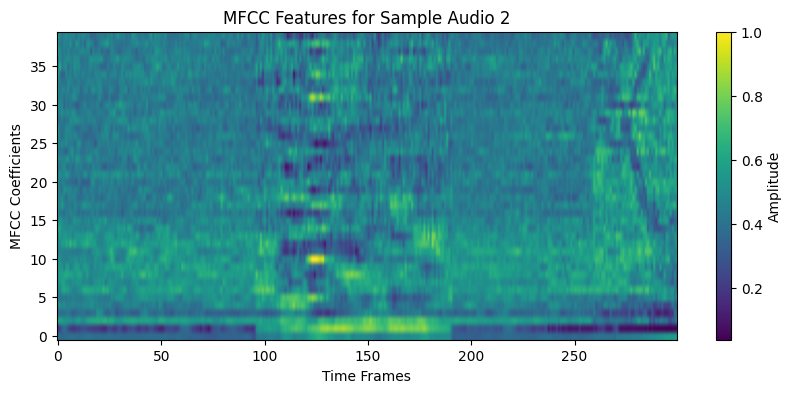

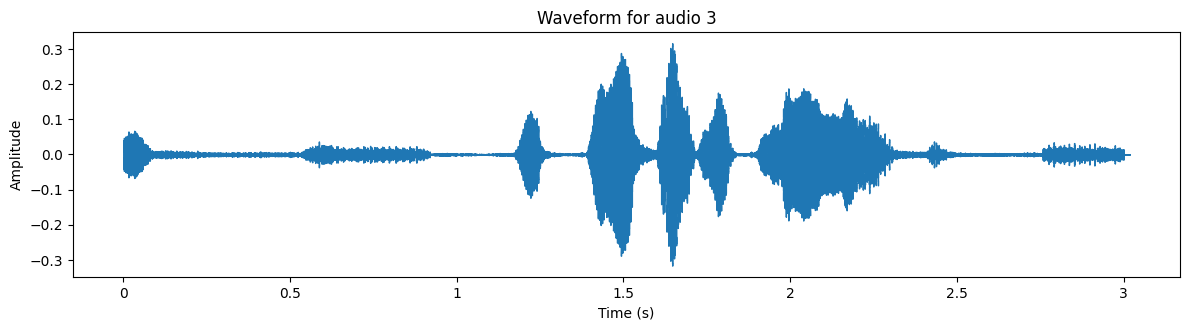

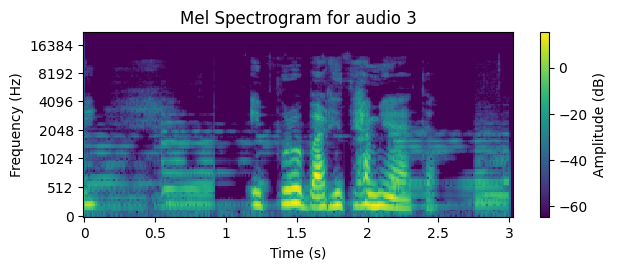

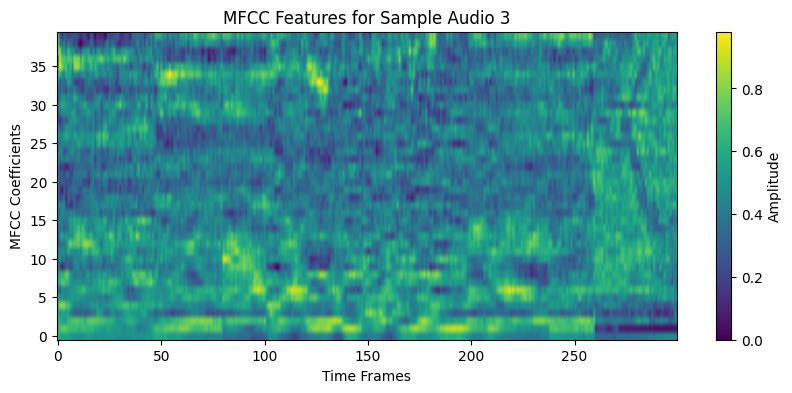

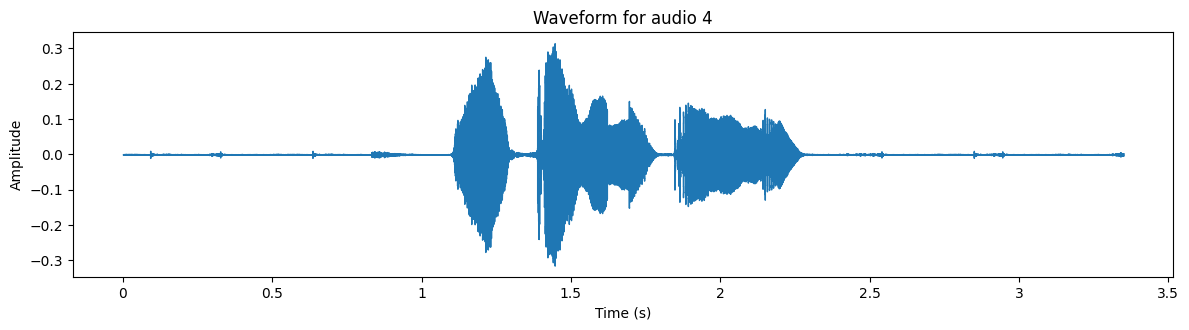

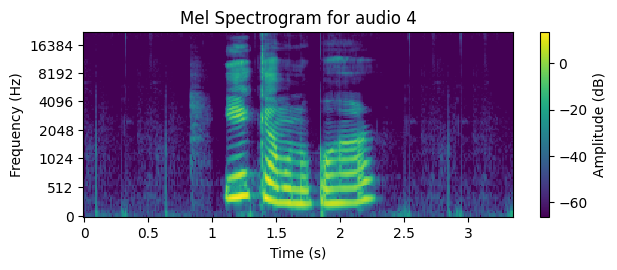

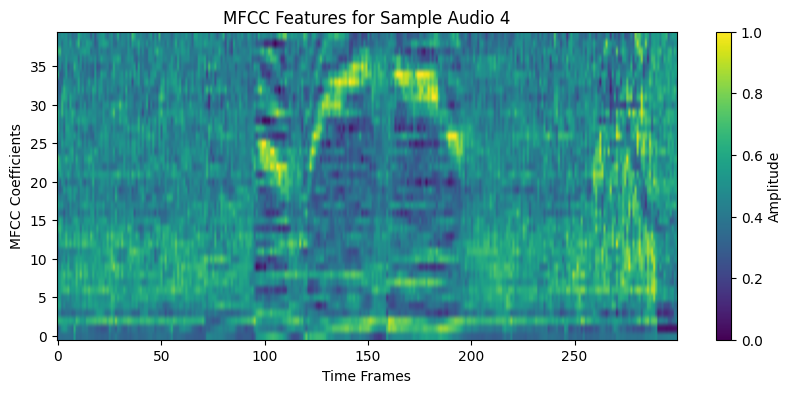

In [64]:
# Plot waveform and spectrogram for comparison
import librosa.display

# file_path = df['audioPaths'].iloc[1466]  # Path to the same sample audio
# audio, sr = librosa.load(file_path, sr=44100)

# plt.figure(figsize=(12, 6))

# Plot waveform
def showwave(audio,num):
  plt.figure(figsize=(12, 6))
  plt.subplot(2, 1, 1)
  librosa.display.waveshow(audio, sr=sr)
  plt.title('Waveform for audio ' + str(num))
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.tight_layout()
  plt.show()

# Plot spectrogram
def showspec(audio,num):
  plt.subplot(2, 1, 2)
  spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=512)
  log_spectrogram = librosa.power_to_db(spectrogram)
  librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
  plt.title('Mel Spectrogram for audio ' + str(num))
  plt.colorbar(label='Amplitude (dB)')
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.tight_layout()
  plt.show()

# plt.tight_layout()
# plt.show()

# Select a sample MFCC from the dataframe for visualization
# sample_mfcc = df['mfcc_features'].iloc[1466]  # Select the first audio file's MFCC features

def showmfcc(mfcc,num):
  # Plot the MFCC features
  plt.figure(figsize=(10, 4))
  plt.imshow(sample_mfcc, aspect='auto', origin='lower', cmap='viridis')
  plt.title('MFCC Features for Sample Audio ' + str(num))
  plt.xlabel('Time Frames')
  plt.ylabel('MFCC Coefficients')
  plt.colorbar(label='Amplitude')
  plt.show()


for i in range(5):
  file_path = train_df['audioPaths'].iloc[i]  # Path to the same sample audio
  audio, sr = librosa.load(file_path, sr=44100)
  sample_mfcc = train_df['mfcc_features'].iloc[i]  # Select the first audio file's MFCC features
  showwave(audio,i)
  showspec(audio,i)
  showmfcc(sample_mfcc,i)



In [65]:
# # Define the Fully Connected Network
# def create_fully_connected_network(input_dim, num_classes):
#     model = models.Sequential([
#         # Input layer (flattened MFCC features)
#         layers.Input(shape=(input_dim,)),

#         # First hidden layer with 1024 units and ReLU activation
#         layers.Dense(1024, activation='relu'),

#         # Second hidden layer with 512 units and ReLU activation
#         layers.Dense(512, activation='relu'),

#         # Output layer with 'num_classes' units and softmax activation
#         layers.Dense(num_classes, activation='softmax')
#     ])

#     return model

# # Parameters
# input_dim = 40 * 300  # Flattened MFCC dimensions (40 coefficients × 300 frames)
# num_classes = 5       # Number of target classes

# # Create the model
# model = create_fully_connected_network(input_dim, num_classes)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()

# Import model libraries

In [66]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preparing stuff for model

In [67]:
# 1. Flatten MFCC Features
def flatten_mfcc(dataframe):
    dataframe['flattened_mfcc'] = dataframe['mfcc_features'].apply(lambda x: x.flatten())
    return np.array(dataframe['flattened_mfcc'].tolist())

train_df['mfcc_features'] = train_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
val_df['mfcc_features'] = val_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
test_df['mfcc_features'] = test_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))

# Flatten MFCC features for train, validation, and test sets
X_train = flatten_mfcc(train_df)
X_val = flatten_mfcc(val_df)
X_test = flatten_mfcc(test_df)

# 2. Prepare Labels
target_mapping = {'happy': 0, 'sad': 1, 'angry': 2, 'surprise': 3, 'neutral': 4 , 'disgust': 5}
y_train = np.array([target_mapping[label] for label in train_df['labels']])
y_val = np.array([target_mapping[label] for label in val_df['labels']])
y_test = np.array([target_mapping[label] for label in test_df['labels']])

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=6)
y_val_cat = to_categorical(y_val, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# Using proposed model -  CNN-Transformer Hybrid Approach

In [68]:
# Extract MFCC features
train_df['mfcc_features'] = train_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
val_df['mfcc_features'] = val_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
test_df['mfcc_features'] = test_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))

# Reshape MFCC features for train, validation, and test sets
X_train = np.stack(train_df['mfcc_features'].values).transpose(0, 2, 1) # Shape (batch_size, 300, 40)
X_val = np.stack(val_df['mfcc_features'].values).transpose(0, 2, 1)     # Shape (batch_size, 300, 40)
X_test = np.stack(test_df['mfcc_features'].values).transpose(0, 2, 1)   # Shape (batch_size, 300, 40)

# Prepare Labels
target_mapping = {'happy': 0, 'sad': 1, 'angry': 2, 'surprise': 3, 'neutral': 4, 'disgust': 5}
y_train = np.array([target_mapping[label] for label in train_df['labels']])
y_val = np.array([target_mapping[label] for label in val_df['labels']])
y_test = np.array([target_mapping[label] for label in test_df['labels']])

# Convert labels to categorical format
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=6)
y_val_cat = to_categorical(y_val, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# Verify shapes
print("X_train shape:", X_train.shape)       # Should be (num_samples_train, 300, 40)
print("X_val shape:", X_val.shape)           # Should be (num_samples_val, 300, 40)
print("X_test shape:", X_test.shape)         # Should be (num_samples_test, 300, 40)
print("y_train_cat shape:", y_train_cat.shape) # Should be (num_samples_train, num_classes=5)
print("y_val_cat shape:", y_val_cat.shape)     # Should be (num_samples_val, num_classes=5)
print("y_test_cat shape:", y_test_cat.shape)   # Should be (num_samples_test, num_classes=5)


X_train shape: (1656, 300, 40)
X_val shape: (237, 300, 40)
X_test shape: (474, 300, 40)
y_train_cat shape: (1656, 6)
y_val_cat shape: (237, 6)
y_test_cat shape: (474, 6)


# Code recieved from actual people

In [69]:
from tensorflow.keras import layers, models, regularizers

def build_cnn_backbone(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Modified to match PyTorch architecture
    x = layers.Conv1D(64, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool1D(3)(x)
    
    return models.Model(inputs, x, name="modified_cnn_backbone")

def transformer_block(x, num_heads, key_dim, mlp_dim, prefix):
    # Multi-head attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=key_dim,
        name=f"{prefix}_attn"
    )(x, x)
    
    # First residual connection
    x = layers.Add(name=f"{prefix}_add1")([x, attn_output])
    x = layers.LayerNormalization(name=f"{prefix}_ln1")(x)
    
    # MLP
    mlp_output = layers.Dense(mlp_dim, activation='relu', name=f"{prefix}_mlp")(x)
    mlp_output = layers.Dense(key_dim, name=f"{prefix}_mlp_out")(mlp_output)
    
    # Second residual connection
    x = layers.Add(name=f"{prefix}_add2")([x, mlp_output])
    x = layers.LayerNormalization(name=f"{prefix}_ln2")(x)
    
    return x

def build_model(input_shape, num_classes):
    # Input
    inputs = layers.Input(shape=input_shape)
    
    # CNN Backbone
    cnn_backbone = build_cnn_backbone(input_shape)
    cnn_output = cnn_backbone(inputs)  # Shape: (None, 31, 64)
    
    # Attention blocks
    z = layers.Lambda(lambda x: x)(cnn_output)  # Save original features
    
    # First transformer block
    x = transformer_block(cnn_output, num_heads=4, key_dim=64, mlp_dim=64, prefix="block1")
    x = layers.ReLU()(x)
    
    # Second transformer block
    x = transformer_block(x, num_heads=4, key_dim=64, mlp_dim=64, prefix="block2")
    x = layers.ReLU()(x)
    
    # Concatenate CNN features with transformer output
    combined = layers.Concatenate(axis=-1)([z, x])  # Shape: (None, 31, 128)
    
    # Classifier head
    x = layers.Flatten()(combined)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs)

# Model compilation
model = build_model((300, 40), 6)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300, 40)]    0           []                               
                                                                                                  
 modified_cnn_backbone (Functio  (None, 33, 64)      70720       ['input_5[0][0]']                
 nal)                                                                                             
                                                                                                  
 block1_attn (MultiHeadAttentio  (None, 33, 64)      66368       ['modified_cnn_backbone[0][0]',  
 n)                                                               'modified_cnn_backbone[0][0]']  
                                                                                            

## Defining the CNN-Transformer Hybrid Model

In [70]:
from tensorflow.keras.regularizers import l2
# CNN Backbone (Increased filters)
def build_cnn_backbone(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Conv1D Stack with More Filters
    x = layers.Conv1D(filters=512, kernel_size=5, strides=1, padding="same", activation="relu",
                      kernel_regularizer=l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters=128, kernel_size=10, strides=10, padding='valid', activation='relu',
                      kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.3)(x)

    return models.Model(inputs, x, name="cnn_backbone")

# Transformer Encoder (Increased complexity)
def build_transformer_encoder(input_shape, num_heads=6, ff_dim=512, num_layers=3):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    positions = layers.Embedding(input_dim=input_shape[0], output_dim=128)(positions)  # Increased Embedding
    x = inputs + positions

    # Transformer Encoder Stack
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=128)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(128)(ffn_output)  # Match embedding size
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    return models.Model(inputs, x, name="transformer_encoder")

# Full Model
def build_model(input_shape, num_classes):
    # CNN Backbone
    cnn_backbone = build_cnn_backbone(input_shape)

    # Transformer Encoder
    transformer_input_shape = cnn_backbone.output_shape[1:]
    transformer_encoder = build_transformer_encoder(transformer_input_shape)

    # Combine CNN and Transformer
    cnn_output = cnn_backbone.output
    transformer_output = transformer_encoder(cnn_output)
    combined_output = layers.Concatenate(axis=-1)([cnn_output, transformer_output])

    # Global Average Pooling Instead of Flatten
    x = layers.GlobalAveragePooling1D()(combined_output)
    x = layers.Dense(256, activation="relu")(x)  # Increase Dense Layer Size
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(cnn_backbone.input, outputs, name="cnn_transformer_model")

# Reshape input data
X_train = X_train.reshape(-1, 300, 40)
X_val = X_val.reshape(-1, 300, 40)

# Build and Compile the Model
model = build_model((300, 40), num_classes=6)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "cnn_transformer_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300, 40)]    0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 300, 512)     102912      ['input_7[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 300, 512)    2048        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 300, 256)     393472      ['batch_norma

In [71]:
# Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn-transformer.h5', monitor='val_loss', save_best_only=True)
]

# Train the Model
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                    epochs=100, batch_size=32, class_weight=class_weights_dict,
                    callbacks=callbacks)

Epoch 1/100
52/52 [==============================] - 4s 32ms/step - loss: 8.5119 - accuracy: 0.3092 - val_loss: 8.7665 - val_accuracy: 0.2405
Epoch 2/100
52/52 [==============================] - 1s 23ms/step - loss: 7.7837 - accuracy: 0.4420 - val_loss: 8.1213 - val_accuracy: 0.2827
Epoch 3/100
52/52 [==============================] - 1s 24ms/step - loss: 7.2056 - accuracy: 0.5103 - val_loss: 7.6832 - val_accuracy: 0.3165
Epoch 4/100
52/52 [==============================] - 1s 23ms/step - loss: 6.7068 - accuracy: 0.5864 - val_loss: 6.9948 - val_accuracy: 0.4726
Epoch 5/100
52/52 [==============================] - 1s 23ms/step - loss: 6.2878 - accuracy: 0.6455 - val_loss: 6.4704 - val_accuracy: 0.5190
Epoch 6/100
52/52 [==============================] - 1s 24ms/step - loss: 5.9536 - accuracy: 0.6944 - val_loss: 6.1720 - val_accuracy: 0.5654
Epoch 7/100
52/52 [==============================] - 1s 24ms/step - loss: 5.6105 - accuracy: 0.7476 - val_loss: 6.0032 - val_accuracy: 0.5865
Epoch 

In [72]:
X_test = X_test.reshape(-1, 300, 40)  # Reshape to (294, 300, 40)

print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

X_test shape: (474, 300, 40)
y_test_cat shape: (474, 6)
15/15 [==============================] - 0s 8ms/step - loss: 4.5497 - accuracy: 0.7511
Test Loss: 4.5497
Test Accuracy: 0.7511


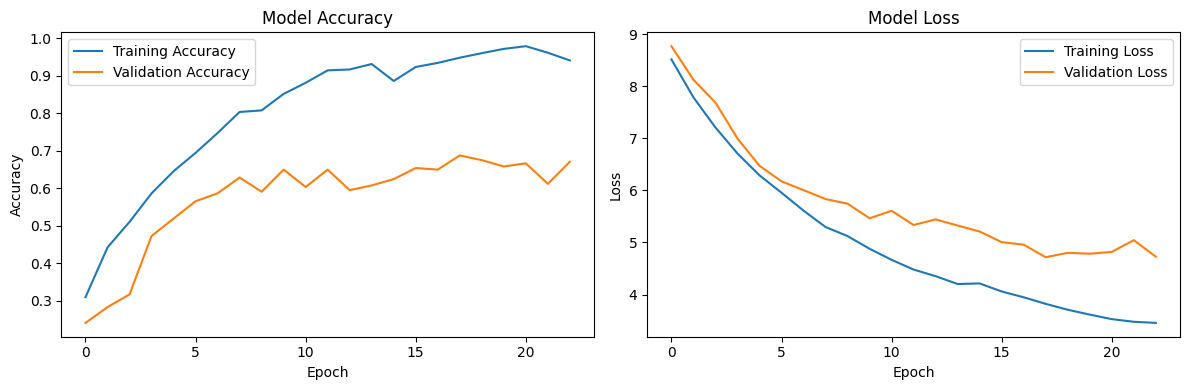

In [73]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

15/15 [==============================] - 0s 7ms/step


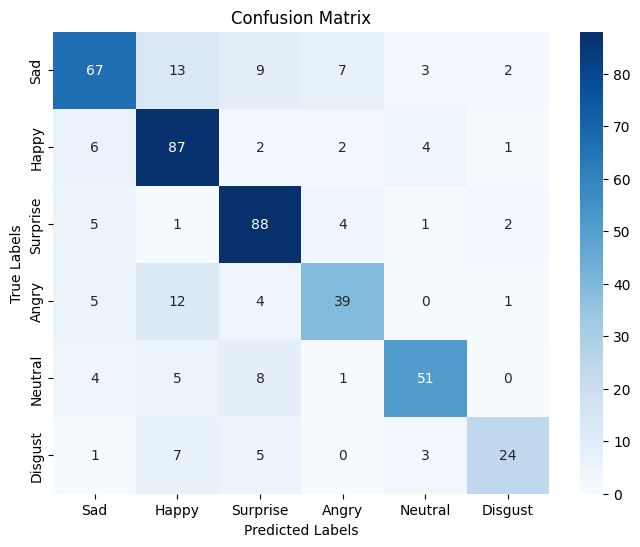

Classification Report:
              precision    recall  f1-score   support

         Sad       0.76      0.66      0.71       101
       Happy       0.70      0.85      0.77       102
    Surprise       0.76      0.87      0.81       101
       Angry       0.74      0.64      0.68        61
     Neutral       0.82      0.74      0.78        69
     Disgust       0.80      0.60      0.69        40

    accuracy                           0.75       474
   macro avg       0.76      0.73      0.74       474
weighted avg       0.76      0.75      0.75       474

Overall Accuracy: 0.7511


In [74]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


# Assuming model, X_test, and y_test are defined
# Convert predictions to class indices
X_test = X_test.reshape(-1, 300, 40)  # Reshape to (294, 300, 40)

y_pred_classes = np.argmax(model.predict(X_test), axis=1)  # Get predicted labels

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names (Modify this according to your dataset)
class_names = ['Sad', 'Happy', 'Surprise', 'Angry', 'Neutral', 'Disgust']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and accuracy
report = classification_report(y_test, y_pred_classes, target_names=class_names)
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the results
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy:.4f}")

In [75]:
!python -V

Python 3.10.16
